# import

In [32]:
import pandas as pd
from collections import Counter

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 300)
pd.options.display.float_format = '{:.5f}'.format
sns.set_style("whitegrid")
colors_nude = ['#e0798c','#65365a','#da8886','#cfc4c4','#dfd7ca']
%matplotlib inline
tqdm.pandas()

/usr/local/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# データの読み込み

In [10]:
DATA_DIR = './data/ml-25m/'
df = pd.read_csv(DATA_DIR + 'ratings.csv')

In [11]:
df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [17]:
df['movieId'].value_counts()

356       81491
318       81482
296       79672
593       74127
2571      72674
          ...  
142782        1
63141         1
135021        1
206712        1
190761        1
Name: movieId, Length: 59047, dtype: int64

In [18]:
df['userId'].value_counts()

72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
          ...  
52927        20
43931        20
27547        20
27546        20
39653        20
Name: userId, Length: 162541, dtype: int64

# データの前処理

## データをサンプリングする

In [20]:
# 出現回数の多いuserとmovieに絞る
user_ids_count = Counter(df.userId)
movie_ids_count = Counter(df.movieId)

n = 10000
m = 2000

user_ids = [u for u, c in user_ids_count.most_common(n)]
movie_ids = [m for m, c in movie_ids_count.most_common(m)]

In [21]:
len(user_ids), len(movie_ids)

(10000, 2000)

In [23]:
df_small = df[df.userId.isin(user_ids) & df.movieId.isin(movie_ids)]

In [24]:
df_small

,userId,movieId,rating,timestamp
254,3,1,4.0,1439472215
255,3,29,4.5,1484754967
256,3,32,4.5,1439474635
257,3,50,5.0,1439474391
258,3,111,4.0,1484753849
...,...,...,...,...
24996934,162519,4718,3.0,1000946228
24996935,162519,4734,4.0,1000948027
24996938,162519,4855,5.0,1001884147
24996939,162519,4857,5.0,1001886067


## indexを付与する

In [26]:
user_id_map = {}
for i, u_id in enumerate(user_ids):
    user_id_map[u_id] = i
    
movie_id_map = {}
for i, m_id in enumerate(movie_ids):
    movie_id_map[m_id] = i

In [28]:
df_small.loc[:, 'user_idx'] = df_small.progress_apply(lambda row: user_id_map[row.userId], axis=1)
df_small.loc[:, 'movie_idx'] = df_small.progress_apply(lambda row: movie_id_map[row.movieId], axis=1)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [29]:
df_small

,userId,movieId,rating,timestamp,user_idx,movie_idx
254,3,1,4.0,1439472215,6014,12
255,3,29,4.5,1484754967,6014,730
256,3,32,4.5,1439474635,6014,27
257,3,50,5.0,1439474391,6014,14
258,3,111,4.0,1484753849,6014,95
...,...,...,...,...,...,...
24996934,162519,4718,3.0,1000946228,9035,544
24996935,162519,4734,4.0,1000948027,9035,839
24996938,162519,4855,5.0,1001884147,9035,974
24996939,162519,4857,5.0,1001886067,9035,1804


In [30]:
df_small.to_csv(DATA_DIR + 'edited_ratings.csv', index=False)

In [31]:
df_small.describe()

,userId,movieId,rating,timestamp,user_idx,movie_idx
count,5.753390e+06,5.753390e+06,5.753390e+06,5.753390e+06,5.753390e+06,5.753390e+06
mean,8.086876e+04,1.641454e+04,3.431524e+00,1.241369e+09,4.139243e+03,7.163369e+02
std,4.669108e+04,3.163669e+04,1.019871e+00,2.010639e+08,2.912053e+03,5.564813e+02
min,3.000000e+00,1.000000e+00,5.000000e-01,8.280473e+08,0.000000e+00,0.000000e+00
25%,4.009900e+04,1.250000e+03,3.000000e+00,1.076338e+09,1.541000e+03,2.300000e+02
50%,8.007800e+04,2.791000e+03,3.500000e+00,1.210419e+09,3.719000e+03,5.950000e+02
75%,1.209610e+05,6.618000e+03,4.000000e+00,1.449085e+09,6.529000e+03,1.127000e+03
max,1.625190e+05,1.951590e+05,5.000000e+00,1.574328e+09,9.999000e+03,1.999000e+03


# Training

In [44]:
user_num = df_small.user_idx.max() + 1 # number of users
movie_num = df_small.movie_idx.max() + 1 # number of movies

In [53]:
print(user_num, movie_num)

10000 2000


In [36]:
# train, testの分割
train, test = train_test_split(df_small, test_size=0.3, shuffle=True, random_state=42)

In [54]:
print(train.shape, test.shape)

(4027373, 6) (1726017, 6)


In [38]:
test

,userId,movieId,rating,timestamp,user_idx,movie_idx
11041147,71790,6863,4.00000,1136188742,1354,348
18205196,117909,78772,2.00000,1501517183,7200,1896
24529415,159403,1645,1.50000,1105111193,6426,381
23723312,154077,54001,3.50000,1448208740,3250,339
15187599,98421,3654,3.00000,1010624269,1091,1710
...,...,...,...,...,...,...
3021545,19936,116797,2.50000,1446781713,770,300
15751551,101984,708,2.50000,1147992481,9924,356
5300407,34383,784,3.00000,1115590172,8470,335
15966446,103523,778,4.50000,1200238372,3918,98


In [40]:
def create_model(user_num: int, movie_num: int, k: int = 10) -> tf.keras.models.Model:
    """kerasでMatrix Factorizationのネットワークモデルを構築する

    Args:
        user_num (int): ユニークユーザー数
        question_num (int): ユニーク質問数
        k (int): 埋め込み層の次元数

    Returns:
        tf.keras.models.Model: モデルインスタンス
    """

    u = tf.keras.layers.Input(shape=(1,))
    m = tf.keras.layers.Input(shape=(1,))
    u_embedding = tf.keras.layers.Embedding(user_num, k)(u)
    m_embedding = tf.keras.layers.Embedding(movie_num, k)(m)
    u_bias = tf.keras.layers.Embedding(user_num, 1)(u)
    m_bias = tf.keras.layers.Embedding(movie_num, 1)(m)

    x = tf.keras.layers.Dot(axes=2)([u_embedding, m_embedding])
    x = tf.keras.layers.Add()([x, u_bias, m_bias])
    x = tf.keras.layers.Flatten()(x)

    model = tf.keras.models.Model(inputs=[u, m], outputs=x)
    opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=opt,
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    return model

In [46]:
model = create_model(user_num, movie_num)

In [47]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        100000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        20000       input_2[0][0]                    
_______________________________________________________________________________________

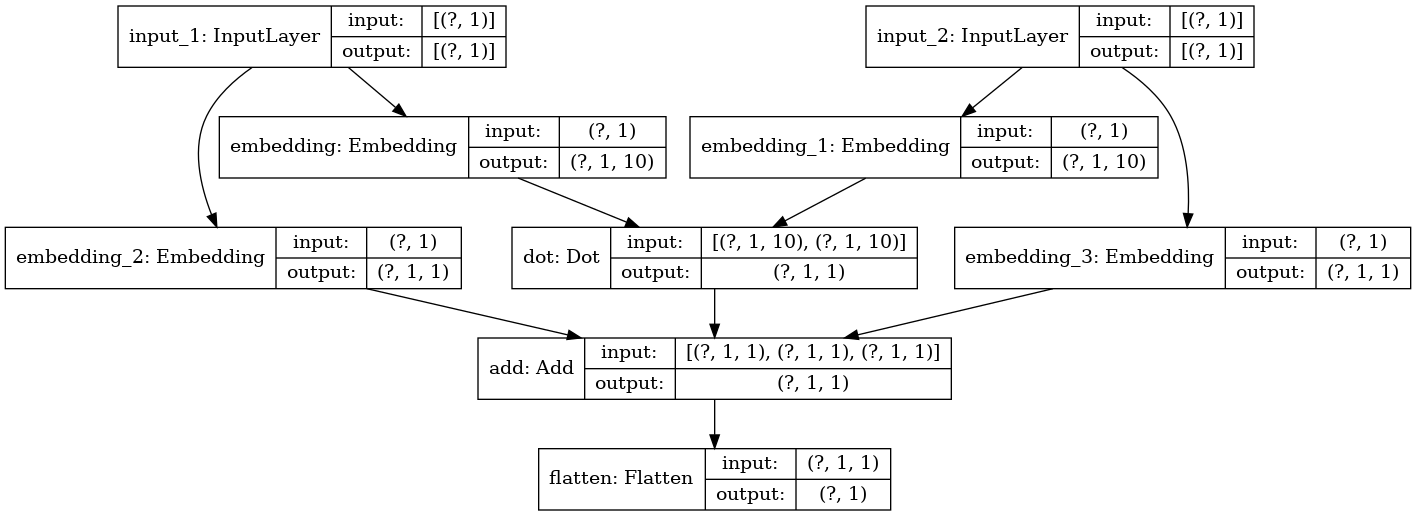

In [48]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [49]:
# callback関数を定義
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=0,
    )
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'keras.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=0,
)

In [52]:
# 学習
result = model.fit(
    x=[train.user_idx.values, train.movie_idx.values],
    y=train.rating.values,
    epochs=200,
    batch_size=1024,
    validation_data=(
        [test.user_idx.values, test.movie_idx.values],
        test.rating.values
    ),
    callbacks=[early_stopping, checkpoint],
    verbose=1,
)

Epoch 1/200
3933/3933 [==============================] - 9s 2ms/step - loss: 2.0342 - root_mean_squared_error: 1.4263 - val_loss: 0.7522 - val_root_mean_squared_error: 0.8673
Epoch 2/200
3933/3933 [==============================] - 10s 3ms/step - loss: 0.7092 - root_mean_squared_error: 0.8421 - val_loss: 0.6880 - val_root_mean_squared_error: 0.8295
Epoch 3/200
3933/3933 [==============================] - 9s 2ms/step - loss: 0.6809 - root_mean_squared_error: 0.8252 - val_loss: 0.6776 - val_root_mean_squared_error: 0.8232
Epoch 4/200
3933/3933 [==============================] - 10s 2ms/step - loss: 0.6751 - root_mean_squared_error: 0.8216 - val_loss: 0.6751 - val_root_mean_squared_error: 0.8216
Epoch 5/200
3933/3933 [==============================] - 10s 2ms/step - loss: 0.6734 - root_mean_squared_error: 0.8206 - val_loss: 0.6741 - val_root_mean_squared_error: 0.8210
Epoch 6/200
3933/3933 [==============================] - 9s 2ms/step - loss: 0.6727 - root_mean_squared_error: 0.8202 - va

In [ ]:
# plot losses
plt.plot(result.history['loss'], label="train loss")
plt.plot(result.history['val_loss'], label="test loss")
plt.legend()
plt.show()

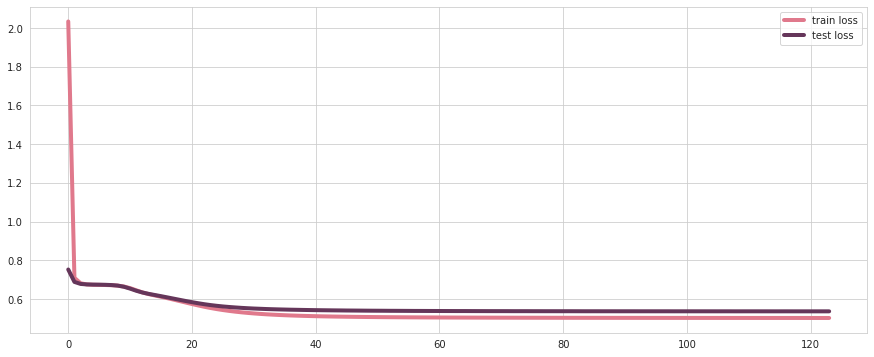

In [71]:
sns.set_context({"lines.linewidth": 4})
plt.subplots(figsize=(15, 6))
sns.lineplot(data=result.history['loss'], label="train loss", color=colors_nude[0])
sns.lineplot(data=result.history['val_loss'], label="test loss", color=colors_nude[1])
plt.legend()
plt.show()

# レコメンデーション

## 推論結果を利用する

In [74]:
# movieのタイトルを取得する
movie = pd.read_csv(DATA_DIR + 'movies.csv')

In [75]:
movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [77]:
# train, testとマージする
train = pd.merge(train, movie, how='left', on='movieId')
test = pd.merge(test, movie, how='left', on='movieId')

In [82]:
# 推論
test.loc[:, 'pred_rating'] = model.predict([test.user_idx.values, test.movie_idx.values], verbose=1)

53939/53939 [==============================] - 61s 1ms/step


In [107]:
test

,userId,movieId,rating,timestamp,user_idx,movie_idx,title,genres,pred_rating
0,71790,6863,4.00000,1136188742,1354,348,School of Rock (2003),Comedy|Musical,3.98582
1,117909,78772,2.00000,1501517183,7200,1896,"Twilight Saga: Eclipse, The (2010)",Fantasy|Romance|Thriller|IMAX,2.45541
2,159403,1645,1.50000,1105111193,6426,381,The Devil's Advocate (1997),Drama|Mystery|Thriller,3.26561
3,154077,54001,3.50000,1448208740,3250,339,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX,3.86359
4,98421,3654,3.00000,1010624269,1091,1710,"Guns of Navarone, The (1961)",Action|Adventure|Drama|War,3.85960
...,...,...,...,...,...,...,...,...,...
1726012,19936,116797,2.50000,1446781713,770,300,The Imitation Game (2014),Drama|Thriller|War,2.92162
1726013,101984,708,2.50000,1147992481,9924,356,"Truth About Cats & Dogs, The (1996)",Comedy|Romance,3.06626
1726014,34383,784,3.00000,1115590172,8470,335,"Cable Guy, The (1996)",Comedy|Thriller,3.25299
1726015,103523,778,4.50000,1200238372,3918,98,Trainspotting (1996),Comedy|Crime|Drama,4.24652


In [104]:
# 実験
user_id = 91660

# trainで見ているmovie
train.query('userId == @user_id').sort_values('rating', ascending=False).head(20)

,userId,movieId,rating,timestamp,user_idx,movie_idx,title,genres
7829,91660,480,5.00000,1421650244,9893,6,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
2531269,91660,6874,5.00000,1421650583,9893,66,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
3250106,91660,58559,5.00000,1421639655,9893,37,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
894304,91660,112852,5.00000,1421639537,9893,278,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi
2662846,91660,4993,5.00000,1421640534,9893,13,"Lord of the Rings: The Fellowship of the Ring, The (2001)",Adventure|Fantasy
1393765,91660,5989,5.00000,1421696510,9893,104,Catch Me If You Can (2002),Crime|Drama
2645505,91660,68157,5.00000,1421639916,9893,152,Inglourious Basterds (2009),Action|Drama|War
85394,91660,106920,5.00000,1421640041,9893,556,Her (2013),Drama|Romance|Sci-Fi
1952802,91660,1197,5.00000,1421639850,9893,45,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
2568787,91660,112552,5.00000,1421695704,9893,502,Whiplash (2014),Drama


In [105]:
# trainで見ているmovie
train.query('userId == @user_id').sort_values('rating', ascending=True).head(20)

,userId,movieId,rating,timestamp,user_idx,movie_idx,title,genres
1382102,91660,3593,1.00000,1421697092,9893,1401,Battlefield Earth (2000),Action|Sci-Fi
214890,91660,4232,1.50000,1421697105,9893,1170,Spy Kids (2001),Action|Adventure|Children|Comedy
3571302,91660,94677,1.50000,1421650003,9893,1978,"Dictator, The (2012)",Comedy
1873644,91660,2273,1.50000,1421650687,9893,465,Rush Hour (1998),Action|Comedy|Crime|Thriller
3241262,91660,3617,1.50000,1421696958,9893,741,Road Trip (2000),Comedy
3200116,91660,33493,1.50000,1421650768,9893,231,Star Wars: Episode III - Revenge of the Sith (2005),Action|Adventure|Sci-Fi
639061,91660,3979,2.00000,1421697177,9893,1475,Little Nicky (2000),Comedy
3264628,91660,52722,2.00000,1421639962,9893,766,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX
683926,91660,86911,2.00000,1421649855,9893,1443,"Hangover Part II, The (2011)",Comedy
3200665,91660,6287,2.00000,1421697138,9893,1035,Anger Management (2003),Comedy


In [108]:
# レコメンドされるmovie
test.query('userId == @user_id').sort_values('pred_rating', ascending=False).head(20)

,userId,movieId,rating,timestamp,user_idx,movie_idx,title,genres,pred_rating
970868,91660,79132,5.00000,1421639649,9893,42,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,4.77859
470151,91660,81591,4.00000,1421640044,9893,380,Black Swan (2010),Drama|Thriller,4.67730
879338,91660,7361,4.50000,1421695632,9893,70,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.62473
1044795,91660,93840,5.00000,1421650651,9893,980,"Cabin in the Woods, The (2012)",Comedy|Horror|Sci-Fi|Thriller,4.60026
442858,91660,104879,4.50000,1421640088,9893,1169,Prisoners (2013),Drama|Mystery|Thriller,4.51335
464683,91660,48516,4.00000,1421639946,9893,125,"Departed, The (2006)",Crime|Drama|Thriller,4.46264
652590,91660,60069,4.50000,1421650404,9893,112,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,4.42813
534590,91660,112183,4.00000,1421639531,9893,851,Birdman: Or (The Unexpected Virtue of Ignorance) (2014),Comedy|Drama,4.40553
508973,91660,92259,4.00000,1421639881,9893,413,Intouchables (2011),Comedy|Drama,4.40287
665899,91660,89745,4.50000,1421639919,9893,251,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,4.39099


## 重みを利用する

In [112]:
# 埋め込みの重みを取得する
user_emb_layer = model.get_layer('embedding')
movie_emb_layer = model.get_layer('embedding_1')

In [113]:
# チェック
user_emb_layer.get_weights()

[array([[-0.14722721, -0.08666495, -0.0008892 , ..., -0.01305616,
          0.00751371,  0.06231485],
        [-0.10404982, -0.05459712, -0.07873439, ...,  0.07536552,
         -0.04684731,  0.13995676],
        [-0.17638716, -0.046297  , -0.14268105, ...,  0.06629159,
          0.09360901,  0.04298342],
        ...,
        [ 0.15208341,  0.1986825 ,  0.4178815 , ...,  0.01531599,
         -0.30786404, -0.24360956],
        [ 0.33535168,  0.07540957, -0.02305807, ..., -0.21820502,
          0.17481911,  0.02077735],
        [ 0.05630057,  0.16364725, -0.06363606, ...,  0.4316126 ,
         -0.6542749 , -0.12360059]], dtype=float32)]

In [114]:
movie_emb_layer.get_weights()

[array([[-0.9608004 ,  1.1415976 , -0.08057699, ..., -0.36496195,
          0.04300114, -0.1472869 ],
        [-0.5391022 ,  0.532716  ,  0.1279914 , ..., -0.10747181,
         -0.16599815, -0.02180444],
        [ 0.08318041,  0.29608285, -0.21304043, ..., -0.9864936 ,
          0.35270882, -0.40433016],
        ...,
        [ 0.09110155, -0.00912163, -0.5328618 , ..., -0.2447692 ,
          0.0832521 , -0.09725589],
        [ 0.47046503, -0.65397406,  0.16248518, ...,  0.12981908,
          0.54365367,  0.75760853],
        [-0.25807264,  0.41884318, -0.22233725, ...,  0.04141658,
          0.39884543, -0.16540034]], dtype=float32)]

In [115]:
print(user_emb_layer.weights[0].shape ,movie_emb_layer.weights[0].shape)

(10000, 10) (2000, 10)


### コサイン類似度を計算

In [126]:
# utils
_df = df_small[['movieId', 'movie_idx']].drop_duplicates()  # 重複を排除したデータ

def sim_movie(movie_df, movie_idx, asc=False, N=10):
    """類似映画IDTOP:N件を返却する関数
    """
    sim_movie_df = cos_df.iloc[:, movie_idx:movie_idx+1].sort_values(movie_idx, ascending=asc)[:N].reset_index().rename(columns={movie_idx: 'cos_sim', 'index': 'movie_idx'})
    sim_movie_df = pd.merge(sim_movie_df, _df, how='left', on='movie_idx')
    
    return pd.merge(sim_movie_df, movie_df, how='left', on='movieId')


def cos_sim_matrix(matrix):
    """コサイン類似度を計算する関数
    """
    d = matrix @ matrix.T  # item-vector 同士の内積を要素とする行列
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

In [127]:
# movieのコサイン類似度行列を計算
# movie_emb_layer.get_weights()[0]で重みを取得できる
cos_df = cos_sim_matrix(movie_emb_layer.get_weights()[0])
cos_df = pd.DataFrame(cos_df)

In [128]:
cos_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1.00000,0.89986,0.25274,0.44681,0.52829,0.32101,0.51988,0.74611,0.84187,0.39170,0.31546,0.31010,0.30931,0.35354,0.37366,0.48173,0.18423,0.48447,0.17381,0.35156,0.39813,0.52355,0.47366,0.54953,0.47697,0.58510,-0.05214,0.22019,0.72868,0.64683,0.71619,0.29330,0.37483,0.52232,0.42440,0.27695,0.85060,0.33997,0.16237,0.26852,0.14158,0.85403,0.44189,0.05640,0.49835,0.06546,-0.12859,0.52150,0.25403,0.44177,0.12673,0.50225,0.23607,-0.26913,-0.09070,0.32169,0.18761,0.24345,0.16392,0.20736,0.49521,0.17854,0.20442,0.51569,0.68799,0.21108,0.19450,0.57623,0.36169,0.26100,0.16179,0.08737,0.24515,-0.00518,0.16338,0.39598,0.43284,0.44905,0.36531,0.79624,0.03789,-0.18212,0.66902,0.15667,0.40881,0.17001,0.18661,-0.00841,0.92818,0.39072,0.01400,-0.06194,0.10569,-0.05294,0.55642,-0.11884,0.18527,-0.15297,0.11850,0.58905,0.17807,0.09633,0.50932,-0.03714,0.66754,-0.19853,0.02663,0.85914,0.40666,0.12975,0.54809,0.27379,0.02449,0.06896,0.23882,-0.24457,-0.32712,0.06427,0.20411,-0.07097,-0.47484,0.31647,0.32913,0.20618,-0.08227,0.35868,0.26018,0.03561,0.36954,0.83729,0.75364,0.20036,0.17984,0.61658,-0.04235,0.05460,0.32858,0.34449,0.43057,0.36287,0.07470,0.67279,0.26435,0.13211,0.00646,0.72484,0.10841,-0.07311,0.17643,0.13094,0.79570,0.18407,0.31308,0.40552,0.41257,0.09360,0.54550,0.66034,0.10749,0.43102,-0.24647,0.59572,0.47131,0.53292,0.19908,-0.24808,0.14390,0.06157,0.50100,-0.15534,0.06517,0.34565,-0.18604,0.09203,0.28854,0.22716,-0.12139,0.03195,0.37589,0.45593,0.56659,0.39309,0.25847,0.32170,-0.06282,0.32661,-0.13878,0.29087,-0.15235,-0.13755,0.10701,0.01122,-0.09663,0.57386,0.45451,-0.08140,0.16694,-0.31884,0.09102,0.05224,0.22108,0.40803,-0.00770,0.38920,0.74398,0.13581,0.29539,-0.06415,-0.24261,-0.12579,-0.28549,0.04128,0.25317,0.33120,0.01867,0.33182,-0.04009,0.20346,-0.15050,-0.38088,0.46970,0.15265,0.19369,0.35176,-0.24802,0.36465,0.13

In [119]:
# 類似映画を計算してみる
movie_id = 480  # ジュラシック・パーク
movie_idx = train.query('movieId == @movie_id')['movie_idx'].unique()[0]
movie_idx

6

In [132]:
# movie_idxと類似しているmovieを取得
sim_df = sim_movie(movie, movie_idx, False, 20)
sim_df

,movie_idx,cos_sim,movieId,title,genres
0,6,1.00000,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
1,10,0.85757,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
2,23,0.84925,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
3,44,0.76081,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
4,252,0.75901,1127,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
5,156,0.74797,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
6,138,0.74682,2115,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy
7,33,0.74252,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
8,31,0.73818,592,Batman (1989),Action|Crime|Thriller
9,35,0.73635,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller


In [133]:
# 類似していないもの
sim_df = sim_movie(movie, movie_idx, True, 20)
sim_df

,movie_idx,cos_sim,movieId,title,genres
0,1751,-0.74691,728,Cold Comfort Farm (1995),Comedy
1,1498,-0.73964,1885,"Opposite of Sex, The (1998)",Comedy|Drama|Romance
2,1584,-0.72412,6867,"Station Agent, The (2003)",Comedy|Drama
3,1657,-0.70949,60950,Vicky Cristina Barcelona (2008),Comedy|Drama|Romance
4,1424,-0.69464,1834,"Spanish Prisoner, The (1997)",Crime|Drama|Mystery|Thriller
5,1832,-0.67511,67734,Adventureland (2009),Comedy|Drama
6,1294,-0.64770,538,Six Degrees of Separation (1993),Drama
7,1746,-0.64666,5791,Frida (2002),Drama|Romance
8,789,-0.63888,224,Don Juan DeMarco (1995),Comedy|Drama|Romance
9,1315,-0.63765,8873,"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Adventure|Drama


In [134]:
# 類似映画を計算してみる
movie_id = 1  # トイストーリー
movie_idx = train.query('movieId == @movie_id')['movie_idx'].unique()[0]
movie_idx

12

In [135]:
# movie_idxと類似しているmovieを取得
sim_df = sim_movie(movie, movie_idx, False, 20)
sim_df

,movie_idx,cos_sim,movieId,title,genres
0,12,1.00000,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,118,0.96712,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2,57,0.92342,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
3,336,0.91339,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
4,61,0.91105,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
5,166,0.87563,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy
6,32,0.87516,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
7,87,0.85055,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy
8,216,0.84546,50872,Ratatouille (2007),Animation|Children|Drama
9,56,0.84258,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX


In [136]:
sim_df = sim_movie(movie, movie_idx, True, 20)
sim_df

,movie_idx,cos_sim,movieId,title,genres
0,1885,-0.85453,999,2 Days in the Valley (1996),Crime|Film-Noir
1,1895,-0.82867,640,Diabolique (1996),Drama|Thriller
2,1248,-0.79706,2840,Stigmata (1999),Drama|Thriller
3,1802,-0.78018,427,Boxing Helena (1993),Drama|Mystery|Romance|Thriller
4,1909,-0.77438,2827,"Astronaut's Wife, The (1999)",Horror|Sci-Fi|Thriller
5,1328,-0.74717,540,Sliver (1993),Thriller
6,1537,-0.74417,1754,Fallen (1998),Crime|Drama|Fantasy|Thriller
7,1827,-0.73680,5065,"Mothman Prophecies, The (2002)",Drama|Fantasy|Horror|Mystery|Thriller
8,1908,-0.72667,2389,Psycho (1998),Crime|Horror|Thriller
9,1808,-0.70708,550,Threesome (1994),Comedy|Romance
